In [172]:
import numpy as np
import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Parameter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 基础要求

使用简单的深度学习的方法对数据进行细胞类型聚类。

In [123]:
rna = ad.read_h5ad("dataset1.h5ad")
sc.pp.filter_genes_dispersion(rna, n_top_genes=2000) # 预处理，提取 highly variable 的基因

In [124]:
rna

AnnData object with n_obs × n_vars = 9631 × 2000
    var: 'means', 'dispersions', 'dispersions_norm'

In [125]:
rna = rna.to_df().to_numpy()

In [126]:
rna

array([[ 0.,  0.,  0., ...,  0.,  0., 34.],
       [ 0.,  0.,  0., ...,  0.,  0., 38.],
       [ 0.,  0.,  0., ...,  0.,  0., 37.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., 36.],
       [ 0.,  0.,  0., ...,  0.,  0., 11.],
       [ 0.,  0.,  0., ...,  0.,  0., 26.]], dtype=float32)

In [127]:
# 定义 Autoencoder 进行降维和特征学习
# AE 模型由一个编码器和一个解码器组成
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [128]:
def train(model, input_dim, dataloader, epochs, optimizer):
    for epoch in range(epochs):
        for data in dataloader:
            output = model(data)
            output = output.squeeze(1)
            output = output.view(output.size(0), input_dim)
            loss = nn.MSELoss()(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], MSE_loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

In [142]:
input_dim = rna.shape[1]  # 输入维度
latent_dim = 32  # 潜在空间维度
model = Autoencoder(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练
num_epochs = 20
dataloader = DataLoader(dataset=rna, batch_size=128)

In [143]:
train(model, input_dim, dataloader, num_epochs, optimizer)

epoch [1/20], MSE_loss: 2.9579
epoch [2/20], MSE_loss: 2.9577
epoch [3/20], MSE_loss: 2.9576
epoch [4/20], MSE_loss: 2.9575
epoch [5/20], MSE_loss: 2.9577
epoch [6/20], MSE_loss: 2.9580
epoch [7/20], MSE_loss: 2.9581
epoch [8/20], MSE_loss: 2.9591
epoch [9/20], MSE_loss: 2.9614
epoch [10/20], MSE_loss: 2.9007
epoch [11/20], MSE_loss: 2.8907
epoch [12/20], MSE_loss: 2.8869
epoch [13/20], MSE_loss: 2.8844
epoch [14/20], MSE_loss: 2.8826
epoch [15/20], MSE_loss: 2.8815
epoch [16/20], MSE_loss: 2.8804
epoch [17/20], MSE_loss: 2.8796
epoch [18/20], MSE_loss: 2.8790
epoch [19/20], MSE_loss: 2.8789
epoch [20/20], MSE_loss: 2.8780


In [144]:
def test(model, data, n_clusters):
    # 获取训练好的编码器的输出，即数据的特征表示
    with torch.no_grad():
        encoded_data = model.encoder(torch.from_numpy(data)).numpy()
    kmenas = KMeans(n_clusters=n_clusters)
    labels_pred = kmenas.fit_predict(encoded_data)
    return labels_pred

In [145]:
num_clusters = 20
# 使用 KMeans 聚类
labels_pred = test(model, rna, num_clusters)

d:\venvs\env38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [146]:
labels_pred

array([13, 13, 13, ..., 15, 13, 13])

In [147]:
with open('cluster.csv', 'w', encoding='utf8') as f:
    for l in labels_pred:
        f.write(str(l) + '\n')
f.close()

In [148]:
_rna = ad.read_h5ad("dataset1.h5ad")

In [149]:
_rna.obs['cluster'] = labels_pred

d:\venvs\env38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


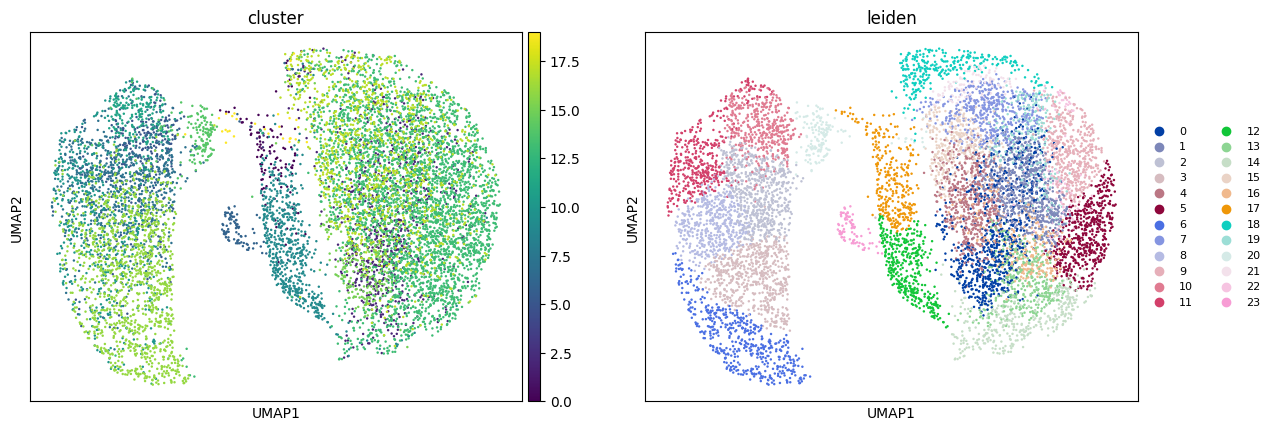

In [150]:
# 和 scanpy 自带的 leiden 分类器比较，查看分类结果
sc.pp.pca(_rna, n_comps=25, svd_solver='arpack')
sc.pp.neighbors(_rna, use_rep='X_pca')
sc.tl.umap(_rna)
sc.tl.leiden(_rna, resolution=1.5)
sc.pl.umap(_rna, color=['cluster','leiden'], legend_fontsize=8)

## 中级要求

使用同样的方法在 dataset2 上做实验，并评估。

In [151]:
# 其他步骤同基础要求
rna2 = ad.read_h5ad("dataset2.h5ad")
sc.pp.filter_genes_dispersion(rna2, n_top_genes=2000)

In [152]:
# 提取标签
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(rna2.obs['cell_type'])

In [153]:
rna2 = rna2.to_df().to_numpy()

In [154]:
input_dim2 = rna2.shape[1]
model2 = Autoencoder(input_dim2, latent_dim)
dataloader2 = DataLoader(dataset=rna2, batch_size=128)

In [155]:
train(model2, input_dim2, dataloader2, num_epochs, optimizer)

epoch [1/20], MSE_loss: 0.3915
epoch [2/20], MSE_loss: 0.3915
epoch [3/20], MSE_loss: 0.3915
epoch [4/20], MSE_loss: 0.3915
epoch [5/20], MSE_loss: 0.3915
epoch [6/20], MSE_loss: 0.3915
epoch [7/20], MSE_loss: 0.3915
epoch [8/20], MSE_loss: 0.3915
epoch [9/20], MSE_loss: 0.3915
epoch [10/20], MSE_loss: 0.3915
epoch [11/20], MSE_loss: 0.3915
epoch [12/20], MSE_loss: 0.3915
epoch [13/20], MSE_loss: 0.3915
epoch [14/20], MSE_loss: 0.3915
epoch [15/20], MSE_loss: 0.3915
epoch [16/20], MSE_loss: 0.3915
epoch [17/20], MSE_loss: 0.3915
epoch [18/20], MSE_loss: 0.3915
epoch [19/20], MSE_loss: 0.3915
epoch [20/20], MSE_loss: 0.3915


In [156]:
num_clusters = 20
labels_pred2 = test(model2, rna2, num_clusters)

d:\venvs\env38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [157]:
# 评估聚类结果
score = adjusted_rand_score(labels_pred2, labels)
print(f'Adjusted Rand Score: {score}')

Adjusted Rand Score: 0.030156080151472427


d:\venvs\env38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


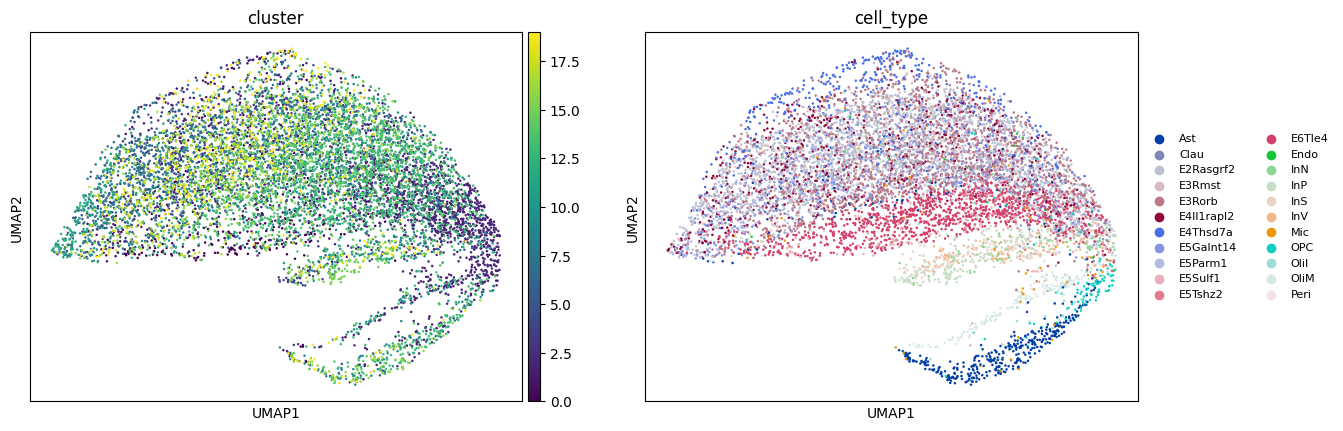

In [159]:
_rna = ad.read_h5ad("dataset2.h5ad")
_rna.obs['cluster'] = labels_pred2
sc.pp.pca(_rna, n_comps=25, svd_solver='arpack')
sc.pp.neighbors(_rna, use_rep='X_pca')
sc.tl.umap(_rna)
sc.pl.umap(_rna, color=['cluster','cell_type'], legend_fontsize=8)

## 高级要求  

使用较为复杂的神经网络进行细胞类型聚类。  
采用论文 [Unsupervised Deep Embedding for Clustering Analysis](https://arxiv.org/abs/1511.06335) 的方法，将数据投影到一个低维特征空间。

In [221]:
rna = ad.read_h5ad("dataset2.h5ad")
sc.pp.filter_genes_dispersion(rna, n_top_genes=2000)

In [222]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(rna.obs['cell_type'])

In [223]:
rna = rna.to_df().to_numpy()

In [224]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=200):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        self.model = nn.Sequential(self.encoder, self.decoder)
    
    def encode(self, x):
        return self.encoder(x)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [225]:
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters=20, hidden=200, cluster_centers=None, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.hidden = hidden
        if cluster_centers is None:
            initial_cluster_centers = torch.zeros(
                self.n_clusters,
                self.hidden,
                dtype=torch.float
            ).cpu()
            nn.init.xavier_uniform_(initial_cluster_centers)
        else:
            initial_cluster_centers = cluster_centers
        self.cluster_centers = Parameter(initial_cluster_centers)
    
    def forward(self, x):
        norm_squared = torch.sum((x.unsqueeze(1) - self.cluster_centers)**2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        numerator = numerator**(float(self.alpha + 1) / 2)
        t_dist = (numerator.t() / torch.sum(numerator, 1)).t()
        return t_dist

In [226]:
class DeepEmbeddingClustering(nn.Module):
    def __init__(self, autoencoder=None, n_clusters=20, hidden=200, cluster_centers=None, alpha=1.0):
        super(DeepEmbeddingClustering, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.hidden = hidden
        self.cluster_centers = cluster_centers
        self.autoencoder = autoencoder
        self.clusteringlayer = ClusteringLayer(self.n_clusters, self.hidden, self.cluster_centers, self.alpha).to(device)
    
    def t_distribution(self, q_):
        weight = (q_ ** 2) / torch.sum(q_, 0)
        return (weight.t() / torch.sum(weight, 1)).t()
    
    def forward(self, x):
        x = self.autoencoder.encode(x)
        return self.clusteringlayer(x)

In [227]:
def pretrain(data, model, epochs):
    para = list(model.parameters())
    optimizer = torch.optim.Adam(para, lr=1e-3, weight_decay=1e-5)
    train_loader = DataLoader(data, batch_size=128, shuffle=False)
    for epoch in range(epochs):
        for d in train_loader:
            d = d.float()
            d = d.to(device)
            output = model(d)
            output = output.squeeze(1)
            output = output.view(output.size(0), data.shape[1])
            loss = nn.MSELoss()(output, d)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], MSE_loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

In [228]:
def train(data, labels, model, epochs):
    features = []
    train_loader = DataLoader(data, batch_size=128, shuffle=False)
    for i, batch in enumerate(train_loader):
        d = batch.float()
        d = d.to(device)
        features.append(model.autoencoder.encode(d).detach().cpu())
    features = torch.cat(features)
    kmeans = KMeans(n_clusters=20, random_state=0).fit(features)
    cluster_centers = kmeans.cluster_centers_
    cluster_centers = torch.tensor(cluster_centers, dtype=torch.float).cpu()
    model.clusteringlayer.cluster_centers = torch.nn.Parameter(cluster_centers)
    labels_pred = kmeans.predict(features)
    accuracy = adjusted_rand_score(labels, labels_pred)
    print('Initial Accuracy: {}'.format(accuracy))

    loss_func = nn.KLDivLoss(size_average=False)
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    print('Training...')
    row = []
    for epoch in range(epochs):
        d = torch.from_numpy(data)
        output = model(d)
        target = model.t_distribution(output).detach()
        out = output.argmax(1)
        loss = loss_func(output.log(), target) / output.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = adjusted_rand_score(labels, out.cpu().numpy())
        row.append([epoch, accuracy])
        print('Epochs: [{}/{}] Accuracy: {} Loss: {}'.format(epoch+1, epochs, accuracy, loss))

    labels_pred = out.cpu().numpy()
    with open('cluster_advanced.csv', 'w', encoding='utf8') as f:
        for l in labels_pred:
            f.write(str(l) + '\n')
    f.close()
    return labels_pred

In [229]:
autoencoder = AutoEncoder(rna.shape[1], 200).to(device)

In [230]:
pretrain(data=rna, model=autoencoder, epochs=20)

epoch [1/20], MSE_loss: 0.1125
epoch [2/20], MSE_loss: 0.0962
epoch [3/20], MSE_loss: 0.0862
epoch [4/20], MSE_loss: 0.0812
epoch [5/20], MSE_loss: 0.0769
epoch [6/20], MSE_loss: 0.0744
epoch [7/20], MSE_loss: 0.0720
epoch [8/20], MSE_loss: 0.0696
epoch [9/20], MSE_loss: 0.0685
epoch [10/20], MSE_loss: 0.0668
epoch [11/20], MSE_loss: 0.0649
epoch [12/20], MSE_loss: 0.0635
epoch [13/20], MSE_loss: 0.0623
epoch [14/20], MSE_loss: 0.0616
epoch [15/20], MSE_loss: 0.0607
epoch [16/20], MSE_loss: 0.0600
epoch [17/20], MSE_loss: 0.0602
epoch [18/20], MSE_loss: 0.0588
epoch [19/20], MSE_loss: 0.0580
epoch [20/20], MSE_loss: 0.0576


In [231]:
dec = DeepEmbeddingClustering(autoencoder=autoencoder, n_clusters=20, hidden=200, cluster_centers=None, alpha=1.0).to(device)

In [232]:
labels_pred3 = train(data=rna, labels=labels, model=dec, epochs=100)

d:\venvs\env38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initial Accuracy: 0.12061601474124788
Training...


d:\venvs\env38\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epochs: [1/100] Accuracy: 0.12061601474124788 Loss: 0.07103574275970459
Epochs: [2/100] Accuracy: 0.08769777956589113 Loss: 0.058612626045942307
Epochs: [3/100] Accuracy: 0.09766140170016917 Loss: 0.08458970487117767
Epochs: [4/100] Accuracy: 0.13683477040194272 Loss: 0.09187260270118713
Epochs: [5/100] Accuracy: 0.17166865905353243 Loss: 0.11431021243333817
Epochs: [6/100] Accuracy: 0.19481695055849452 Loss: 0.14590682089328766
Epochs: [7/100] Accuracy: 0.21273123802345068 Loss: 0.16678127646446228
Epochs: [8/100] Accuracy: 0.216329833231199 Loss: 0.185770645737648
Epochs: [9/100] Accuracy: 0.2183682771687118 Loss: 0.20383025705814362
Epochs: [10/100] Accuracy: 0.2177149068727933 Loss: 0.21869727969169617
Epochs: [11/100] Accuracy: 0.2210209849716099 Loss: 0.2322065532207489
Epochs: [12/100] Accuracy: 0.22834823383099156 Loss: 0.24324585497379303
Epochs: [13/100] Accuracy: 0.23737913610640146 Loss: 0.24990271031856537
Epochs: [14/100] Accuracy: 0.24514786460558669 Loss: 0.254020512104

d:\venvs\env38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


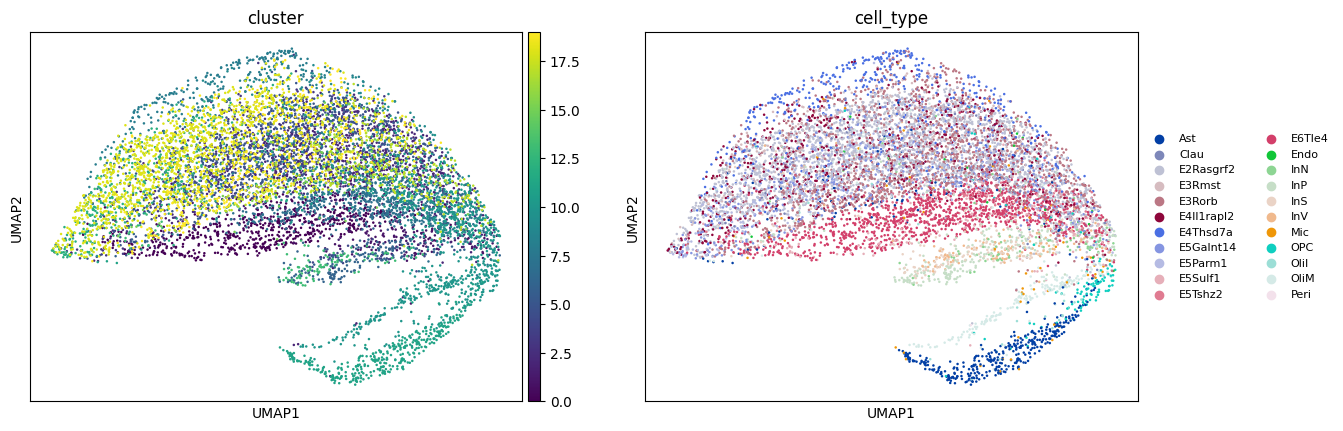

In [233]:
_rna = ad.read_h5ad("dataset2.h5ad")
_rna.obs['cluster'] = labels_pred3
sc.pp.pca(_rna, n_comps=25, svd_solver='arpack')
sc.pp.neighbors(_rna, use_rep='X_pca')
sc.tl.umap(_rna)
sc.pl.umap(_rna, color=['cluster','cell_type'], legend_fontsize=8)